In [19]:
import pandas as pd
import matplotlib.pyplot as plt

import os
scores_df = pd.read_parquet(os.path.expanduser('~/smolmodels/data/scored_sorted_logprobs.parquet'))
scores_df.describe()

,loss,reward_accuracy,reward_margin,chosen_rewards,rejected_rewards,chosen_logps,rejected_logps,mean_chosen_logits,mean_rejected_logits
count,54825.000000,54825.0,54825.0,54825.0,54825.0,54825.000000,54825.000000,54825.000000,54825.000000
mean,0.693359,0.0,0.0,0.0,0.0,-349.923684,-293.267055,0.624996,0.551284
std,0.000000,0.0,0.0,0.0,0.0,297.360411,246.629413,0.636891,0.657809
min,0.693359,0.0,0.0,0.0,0.0,-3080.000000,-3712.000000,-2.855469,-2.929688
25%,0.693359,0.0,0.0,0.0,0.0,-518.000000,-405.750000,0.248413,0.171875
50%,0.693359,0.0,0.0,0.0,0.0,-279.500000,-238.125000,0.667480,0.605957
75%,0.693359,0.0,0.0,0.0,0.0,-112.437500,-109.812500,1.046875,0.991211
max,0.693359,0.0,0.0,0.0,0.0,-2.718750,-4.472656,3.835938,3.466797


array([[<Axes: title={'center': 'chosen_logps'}>,
        <Axes: title={'center': 'rejected_logps'}>],
       [<Axes: title={'center': 'mean_chosen_logits'}>,
        <Axes: title={'center': 'mean_rejected_logits'}>],
       [<Axes: title={'center': 'logprobs_diff'}>, <Axes: >]],
      dtype=object)

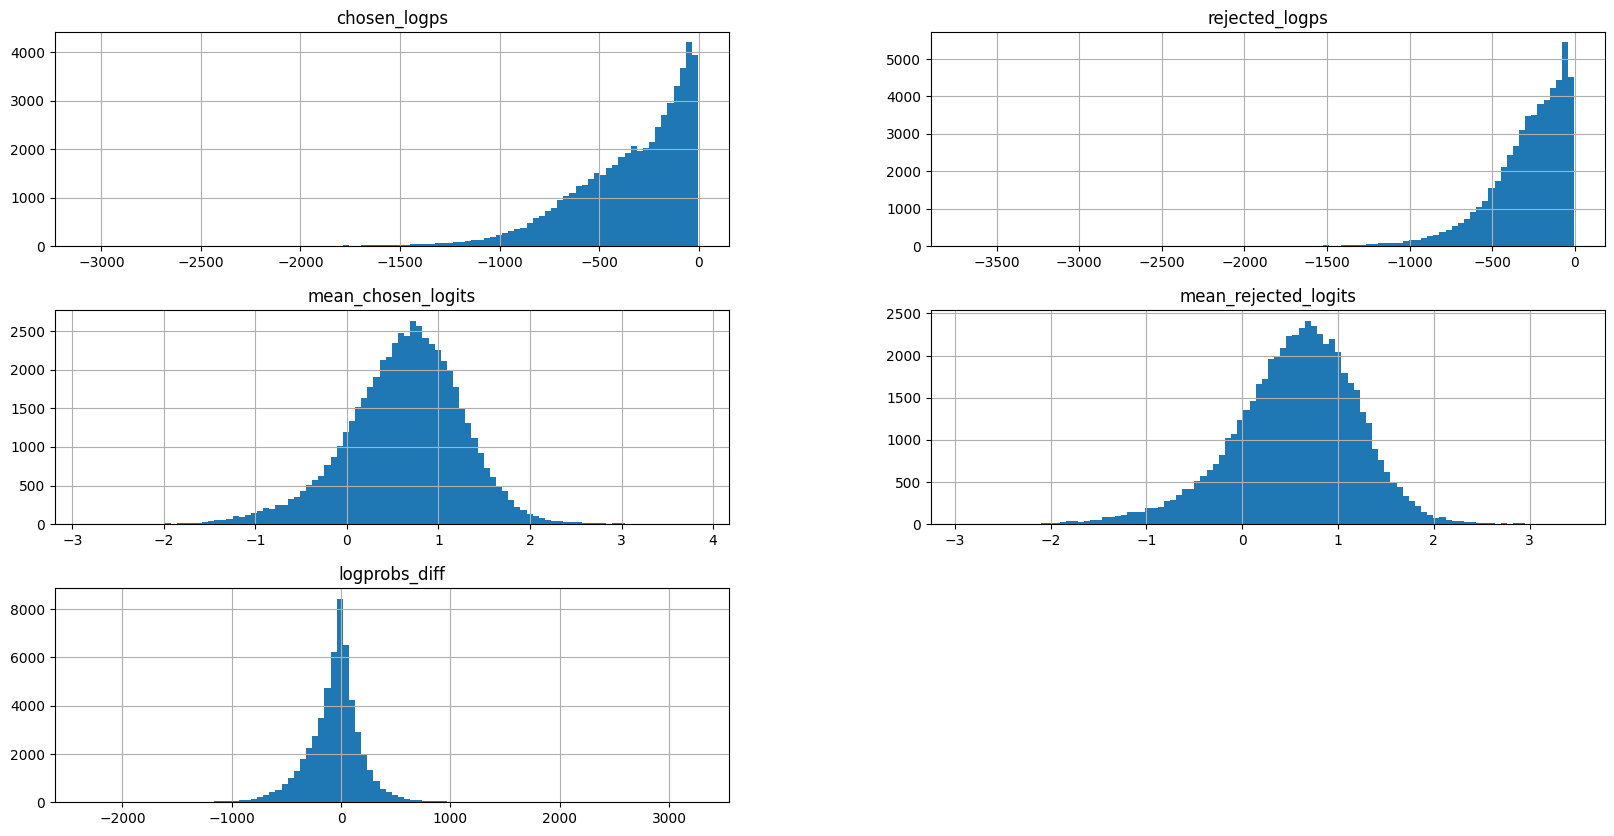

In [25]:
scores_df = scores_df[
    [
        "chosen_logps",
        "rejected_logps",
        "mean_chosen_logits",
        "mean_rejected_logits",
    ]
]
scores_df['logprobs_diff'] = scores_df['chosen_logps'] - scores_df['rejected_logps']
scores_df.hist(bins=100, figsize=(20, 10))